# AMLD 2021

> ##### Machine Learning in Science: Encoding physical constraints and good development practices


## Example 04 - A physics-guided multi-target neural network

In this notebook, we demonstrate a method for encouraging physical consistency of predictions by neural networks. We start by demonstrating how the loss function can be modified to penalize physics violations in a single-target regressor. We then extend this method to a multi-target regressor to show how the loss function can be modified to penalize violations of conservation laws.

### Workshop Organizers

* Dr. Maria Han Veiga (University of Michigan, USA)

* Dr. Miles Timpe (University of Zurich, Switzerland)

### Import libraries

In [1]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import r2_score


# Global seed value
seed = 42

# Set random seeds
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


# Versions can also influence reproducibility
from sys import version
print(f"Python version: {version}")

Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


### Load test data and scalers

In [2]:
neurons = 20

target = 'lr_mass'

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi',
            target]

x_train = pd.read_csv('../datasets/train.csv', usecols=features)
x_test  = pd.read_csv('../datasets/test.csv', usecols=features)

x_train = x_train[x_train['lr_mass'] > 0]
x_test = x_test[x_test['lr_mass'] > 0]

if target != 'lr_mass':
    x_train.pop('lr_mass')
    x_test.pop('lr_mass')

y_train = x_train.pop(target)
y_test  = x_test.pop(target)


# Load scalers and scale targets
y_scaler = load(f"../models/y_scaler_{target}.joblib")

scaled_y_train = y_scaler.transform(y_train.values.reshape(-1, 1))
scaled_y_test  = y_scaler.transform(y_test.values.reshape(-1, 1))
    
# Scale features
x_scaler = load(f"../models/x_scaler.joblib")

scaled_x_train = pd.DataFrame(x_scaler.transform(x_train), columns=x_train.columns)
scaled_x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)

### Setup physics informed neural network

Here, we will first focus on the 'lr_mass' target

In [3]:
# Define model (MLP) using Keras
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Subtract, Lambda, add, ReLU
from keras.callbacks import EarlyStopping

target = 'lr_mass'

_, input_size = scaled_x_train.shape

# Load previously trained model with no knowledge of physical constraints
model_uninformed = keras.models.load_model(f"regressor_mlp_{target}.keras")

# This particular model will predict scaled target values
y_pred_naive = model_uninformed.predict(scaled_x_test)

# Apply inverse scaling to the model predictions
y_scaler = load(f"y_scaler_{target}.joblib")

y_pred_naive = pd.Series(y_scaler.inverse_transform(y_pred_naive.flatten()), name='y_pred').values

## How do we encode the constraint?

We want to penalise the model if the prediction of $0 > m_{lr} > m_{tot}$. This means, if the quantity ($m_{lr} - m_{tot}$) is positive, then we are creating mass out of thin air and we want the loss function to penalize that. We can use a ReLU on this quantity, this way, if this quantity is positive, it will contribute to the loss. If this quantity is 0 or negative, lr_mass is smaller than mtot and it does not contribute to the loss.


$$ ReLU(m_{lr}, m_{tot}) = \left\{
\begin{array}{ll}
      -m_{lr} & \text{for} \quad m_{lr} < 0 \\
      0 & \text{for} \quad 0 \leq m_{lr} \leq m_{tot} \\
      m_{lr} - m_{tot} & \text{for} \quad m_{lr } > m_{tot}
\end{array} \right. $$

In [4]:
# Define model (MLP) using Keras
from keras import backend as K
import tensorflow as tf
import sys

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


# Define custom loss function
def custom_loss_wrapper(input_tensor, overshoot_weight=0.5, positivity_weight=0.5):
    
    @tf.autograph.experimental.do_not_convert
    def custom_loss(y_true, y_pred):
        
        s1 = input_tensor[:,0] 
        
        overshoot = K.mean(ReLU()(Lambda(lambda x: x)(Subtract()([y_pred,s1]))))
        positivity = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred)))
        
        loss = keras.losses.mean_squared_error(y_true, y_pred) \
                + overshoot_weight * overshoot \
                + positivity_weight * positivity
        
        return loss
    
    return custom_loss


# Define model
inputs = Input(shape=(input_size,))
f = Dense(neurons, activation='relu')(inputs)
f = Dense(neurons, activation='relu')(f)
f = Dense(neurons, activation='relu')(f)
outputs = Dense(1)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss=custom_loss_wrapper(inputs), metrics=["mse"])

# Fit model
%time model.fit(x_train, y_train, validation_split=0.05, epochs=500, callbacks=[EarlyStopping(patience=50)], verbose=0)

# Make predictions
y_pred_phys = model.predict(x_test)


# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred_phys)

# Save the model with keras
model.save(f"regressor_mlp_customloss_{target}.keras")

print(f"Prediction r2_score: {r2:.4f}")

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


CPU times: user 1min 44s, sys: 28.5 s, total: 2min 12s
Wall time: 1min 6s
Prediction r2_score: 0.9572


### Correlation plots for single-target regressor

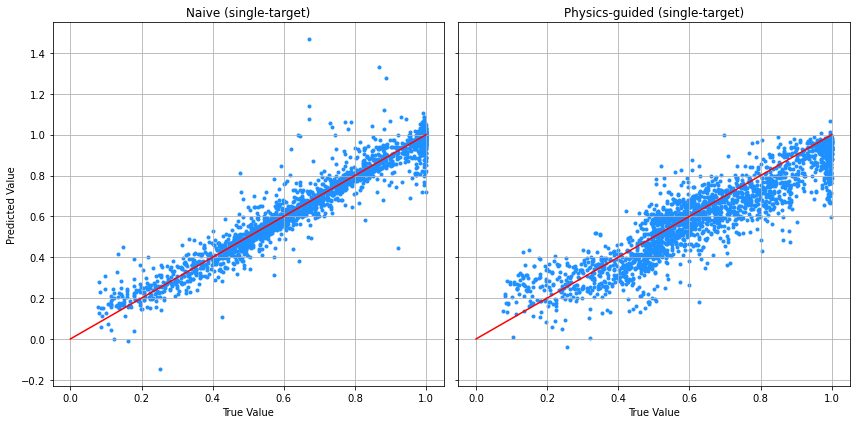

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)


y_test_norm = []
y_naive_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, y_test, y_pred_naive, y_pred_phys):
    y_test_norm.append( y_t / m_tot )
    y_naive_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    

ax = axes[0]

ax.set_title('Naive (single-target)')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

ax.grid(True)

ax.scatter(y_test_norm, y_naive_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = axes[1]

ax.set_title('Physics-guided (single-target)')
ax.set_xlabel('True Value')

ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')

plt.tight_layout()

## Conservation laws with multi-target regressors

Now, we want to predict all masses at the same time, and ensure consistency with the input.

We want to set up a model which will predict the three mass quantities together, and guarantee conservation of mass.

$$ \mathcal{M}(\vec{x}) = \vec{m}, \quad \vec{m} = (m_{lr}, m_{slr}, m_{debris}) $$

under the constraint that

$$ m_{tot} = m_{lr} + m_{slr} + m_{debris} $$

### Load data

Note that we don't scale the features or targets in this case. We could do this, but it would require a bit of extra work within the loss function to apply the inverse scalers to the masses in order to compute the proper sum of the masses. In this case, we have decided to operate on the unscaled data in order to keep things simple and readable.

In [6]:
targets = ['lr_mass','slr_mass','debris_mass']

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi'
           ] + targets

x_train = pd.read_csv('train.csv', usecols=features)
x_test  = pd.read_csv('test.csv', usecols=features)

x_train = x_train[x_train['lr_mass'] > 0]
x_test  = x_test[x_test['lr_mass'] > 0]

y_train = x_train[targets].copy()
y_test  = x_test[targets].copy()

x_train = x_train.drop(targets, axis=1)
x_test  = x_test.drop(targets, axis=1)

### Set up naive multi-target regressor

In [7]:
# Define model
inputs = Input(shape=(input_size,))
f = Dense(neurons, activation='relu')(inputs)
f = Dense(neurons, activation='relu')(f)
f = Dense(neurons, activation='relu')(f)
outputs = Dense(3)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss="mse", metrics=["mse"])


# Fit model
%time model.fit(x_train, y_train, validation_split=0.05, epochs=500, callbacks=[EarlyStopping(patience=50)], verbose=0)

# Make predictions
y_pred_naive = model.predict(x_test)


# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test.values, y_pred_naive, multioutput="raw_values")

print('Naive multi-target regressor')
for i, name in enumerate(targets):
    print(f"{name:>20}\t{r2[i]:.4f}")

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


CPU times: user 1min 35s, sys: 26.5 s, total: 2min 2s
Wall time: 1min 2s
Naive multi-target regressor
             lr_mass	0.9198
            slr_mass	0.5536
         debris_mass	0.8901


### Physics-guided multi-target regressor

We now attempt to impose knowledge of mass conservation on our model. In order to acheive this, we need to predict all three masses simultaneously using a multi-target regressor. We will still use the same 12 input features, but this time we will be predicting three output targets.

In [8]:
# Define model (MLP) using Keras
from keras import backend as K
import tensorflow as tf
import sys

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


# Define custom loss function
def custom_loss_wrapper(input_tensor, overshoot_weight=0.5,positivity_weight=0.5):
    
    @tf.autograph.experimental.do_not_convert
    def custom_loss(y_true,y_pred):
        
        s1 = input_tensor[:,0]
        
        sum_of_mass = K.sum(y_pred, axis=1)
        
        overshoot = K.mean(ReLU()(Lambda(lambda x: x)(Subtract()([sum_of_mass,s1]))))
        
        positivity_lr = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,0])))
        positivity_slr = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,1])))
        positivity_debris = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,2])))
        
        return keras.losses.mean_squared_error(y_true, y_pred) \
                + overshoot_weight * overshoot \
                + positivity_weight * (positivity_lr + positivity_slr + positivity_debris)
    
    return custom_loss


# Define model
inputs = Input(shape=(input_size,))
f = Dense(neurons, activation='relu')(inputs)
f = Dense(neurons, activation='relu')(f)
f = Dense(neurons, activation='relu')(f)
outputs = Dense(3)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss=custom_loss_wrapper(inputs), metrics=["mse"])


# Fit model
%time model.fit(x_train, y_train, validation_split=0.05, epochs=500, callbacks=[EarlyStopping(patience=50)], verbose=0)

# Make predictions
y_pred_phys = model.predict(x_test)


# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred_phys, multioutput="raw_values")

print('Physics-guided multi-target regressor')
for i, name in enumerate(targets):
    print(f"{name:>20}\t{r2[i]:.4f}")

# Save the model with keras
model.save(f"../models/regressor_mlp_constrained_multi_{target}.keras")

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


CPU times: user 2min 6s, sys: 33.7 s, total: 2min 40s
Wall time: 1min 14s
Physics-guided multi-target regressor
             lr_mass	0.9702
            slr_mass	0.8934
         debris_mass	0.9296


### Mass residual histogram

[1639.7329   327.23706  503.58887]


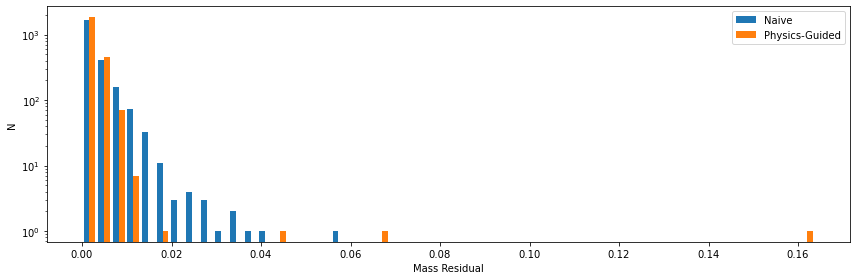

In [9]:
print(np.sum(y_pred_naive, axis=0))

mtot_est_naive = np.sum(y_pred_naive, axis=1)
residual_naive = (x_test.values[:,0] - mtot_est_naive)**2.

mtot_est_phys = np.sum(y_pred_phys, axis=1)
residual_phys = (x_test.values[:,0] - mtot_est_phys)**2.

fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.hist([residual_naive, residual_phys], bins=50, label=['Naive', 'Physics-Guided'])

ax.set_xlabel('Mass Residual')

ax.set_ylabel('N')
ax.set_yscale('log')

ax.legend()

plt.tight_layout()